<a id='top_of_page'></a>
## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents

- **[Introduction](#intro)**
- **[Part I - Probability](#probability)**
  - [Read in data](#PartI_read_in_data)
  - [Proportion of Users Converted](#PartI_prop_users_converted)
  - [Number of Non-aligned Entries](#PartI_num_not_aligned)
  - [Create an Aligned Dataframe](#PartI_create_aligned_df)
  - [Assess the New Dataframe](#PartI_assess_new_df)
  - [Calculate Probabilities](#PartI_calc_probabilities)
  - [Assess Probabilities](#PartI_assess_probabilities)
- **[Part II - A/B Test](#ab_test)**
  - [Null and Alternative Hypotheses](#PartII_hypotheses)
  - [Initial Sampling Distribution](#PartII_initial_sampling_distr)
  - [Sampling Distribution of Differences](#PartII_sampling_distr_of_diffs)
  - [Histogram of Differences](#PartII_hist_of_diffs)
  - [Assessment of Sampling Distribution](#PartII_assessment_of_sampling_distr)
  - [Performing a Z test](#PartII_z_test)
- **[Part III - Regression](#regression)**
  - [Create Dummies to Use in Regression Model](#PartIII_create_init_dummies)
  - [Create Initial Regression Model](#PartIII_create_init_regression_model)
  - [Assess p-value of Model](#PartIII_assess_p_value)
  - [Consider Pros & Cons of Adding Other Factors](#PartIII_consider_adding_factors)
  - [Add 'country' Factors](#PartIII_add_country_factors)
  - [Analyze Impact of 'country' on Conversion](#PartIII_analyze_effect_of_additional_factors)
  - [Check for Interaction Between Predictor Variables](#PartIII_check_for_interactions)
- **[Conclusions](#conclusions)**

<a id='intro'></a>
### Introduction
([Top of Page](#top_of_page))

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability
([Top of Page](#top_of_page))

To get started, let's import our libraries.

In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm;

import seaborn as sb
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

<a id='PartI_read_in_data'></a>
([Top of Page](#top_of_page))<br>
`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [5]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [6]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [7]:
num_users = df[['user_id']].user_id.nunique()
num_users

290584

<a id='PartI_prop_users_converted'></a>
([Top of Page](#top_of_page))<br>
d. The proportion of users converted.

In [8]:
users_converted = df[df['converted'] == 1].user_id.nunique()

proportion_converted = users_converted / num_users
proportion_converted

0.12104245244060237

<a id='PartI_num_not_aligned'></a>
([Top of Page](#top_of_page))<br>
e. The number of times the `new_page` and `treatment` don't line up.

In [9]:
# create boolean masks:
treatmentY_and_newPageN = (df['group'] == 'treatment') & (df['landing_page'] != 'new_page')
treatmentN_and_newPageY = (df['group'] != 'treatment') & (df['landing_page'] == 'new_page')
num_notAligned = df[treatmentY_and_newPageN].shape[0] + df[treatmentN_and_newPageY].shape[0]
num_notAligned

3893

f. Do any of the rows have missing values?

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


* No, none of the rows have missing values.

<a id='PartI_create_aligned_df'></a>
([Top of Page](#top_of_page))<br>
`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [11]:
# # create boolean masks:
treatmentY_and_newPageY = (df['group'] == 'treatment') & (df['landing_page'] == 'new_page')
controlY_and_oldPageY = (df['group'] == 'control') & (df['landing_page'] == 'old_page')
df2 = df[(treatmentY_and_newPageY) | (controlY_and_oldPageY)]    # returns a df with only aligned rows

# NOTE - to return a df with only unaligned rows:
# df[~((treatmentY_and_newPageY) | (controlY_and_oldPageY))]

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

# # A multi-line approach:
# cond1 = (df2['group'] == 'treatment')
# cond2 = (df2['landing_page'] == 'new_page')
# df2[( cond1 == cond2) == False]

0

<a id='PartI_assess_new_df'></a>
([Top of Page](#top_of_page))<br>
`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
num_users_df2 = df2[['user_id']].user_id.nunique()
num_users_df2

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


* Return just the user_id value:

In [15]:
df2[df2['user_id'].duplicated()].iloc[0]['user_id']

773192

c. What is the row information for the repeat **user_id**? 

In [16]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [17]:
df2[['user_id']].user_id.nunique()

290584

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [18]:
indexToDrop = df2[df2['user_id'].duplicated()].index
indexToDrop[0]

2893

In [19]:
df2.drop(index=indexToDrop[0], inplace=True)
df2.head()

/anaconda3/envs/test_env_v03/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Check that only one row was deleted:

In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [21]:
df2[['user_id']].user_id.nunique()

290584

<a id='PartI_calc_probabilities'></a>
([Top of Page](#top_of_page))<br>
`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [22]:
num_users_df2 = df2[['user_id']].user_id.nunique()
num_converted = df2[df2['converted'] == 1].shape[0]

prop_converted_all = num_converted / num_users_df2
prop_converted_all

0.11959708724499628

In [23]:
# another way to calculate the probability:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [24]:
df2_contr = df2[df2['group'] == 'control']

# single line version of probability equations above
prop_converted_contr = df2_contr[df2_contr['converted'] == 1].shape[0] / df2_contr[['user_id']].user_id.nunique()
prop_converted_contr

0.1203863045004612

In [25]:
# another way to calculate the probability:
df2_contr['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [26]:
df2_treat = df2[df2['group'] == 'treatment']

num_users_df2_treat = df2_treat[['user_id']].user_id.nunique()
num_converted_df2_treat = df2_treat[df2_treat['converted'] == 1].shape[0]

prop_converted_treat = num_converted_df2_treat / num_users_df2_treat

# # single line version of probability equations above
# prop_converted_treat = df2_treat[df2_treat['converted'] == 1].shape[0] / df2_treat[['user_id']].user_id.nunique()
prop_converted_treat

0.11880806551510564

In [27]:
# another way to calculate the probability:
df2_treat['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [28]:
df2_newPg = df2[df2['landing_page'] == 'new_page']

df2_newPg['user_id'].count() / df2['user_id'].count()

0.5000619442226688

<a id='PartI_assess_probabilities'></a>
([Top of Page](#top_of_page))<br>
e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**

## |
# >>>>> FILL THIS IN <<<<<
## |

<a id='ab_test'></a>
### Part II - A/B Test
([Top of Page](#top_of_page))

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


<a id='PartII_hypotheses'></a>
`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.<br>
([Top of Page](#top_of_page))

**Put your answer here.**

* The null hypothesis is that the conversion rate for the old page is greater than or equal to the conversion rate of the new page.
* The alternative hypothesis is that the conversion rate for the old page is less than the conversion rate of the new page.
* Expressions for the null ($H_0$) and alternative hypotheses ($H_1$) are as follows:

$$H_0: p_{old} \ge p_{new}$$
$$H_1: p_{old} < p_{new}$$

* Another way to write the null and alternative hypothesis expressions:

$$H_0: p_{old} - p_{new} \ge 0$$
$$H_1: p_{old} - p_{new} < 0$$

<a id='PartII_initial_sampling_distr'></a>
([Top of Page](#top_of_page))<br>
`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br>
* That is: $p_{new} = p_{old} = p_{regardless\_of\_page} $ <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br>
* That is:
  * The sample size for old page ($n_{old}$) == the number of 'old_page' entries in ab_data.csv
  * The sample size for old page ($n_{new}$) == the number of 'new_page' entries in ab_data.csv

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br>

a. What is the **convert rate** for $p_{new}$ under the null? 

* The null assumes that $p_{new} = p_{old} = p_{regardless\_of\_page} $ <br><br>
* And $p_{regardless\_of\_page} $ == <code>df2['converted'].mean() </code>

In [29]:
df2['converted'].mean()

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [30]:
df2['converted'].mean()

0.11959708724499628

c. What is $n_{new}$?

In [31]:
n_new = df2.where(df['landing_page'] == 'new_page').landing_page.count()
n_new

145310

* For reference, here is the dataframe grouped by landing_page:

In [32]:
df2.groupby('landing_page').count()

,user_id,timestamp,group,converted
landing_page,,,,
new_page,145310,145310,145310,145310
old_page,145274,145274,145274,145274


* Also for reference, here is the df2 dataframe when queried by just the "treatment" group

In [33]:
df2.query('group == "treatment"').count()

user_id         145310
timestamp       145310
group           145310
landing_page    145310
converted       145310
dtype: int64

d. What is $n_{old}$?

In [34]:
n_old = df2.where(df['landing_page'] == 'old_page').landing_page.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [35]:
new_page_converted = np.random.choice([1,0], n_new, p=[df2.converted.mean(), (1-df2.converted.mean())])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [36]:
old_page_converted = np.random.choice([1,0], n_old, p=[df2.converted.mean(), (1-df2.converted.mean())])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [37]:
p_diff_single_sample = new_page_converted.mean() - old_page_converted.mean()
p_diff_single_sample

0.00016325506275391422

<a id='PartII_sampling_distr_of_diffs'></a>
([Top of Page](#top_of_page))<br>
h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [38]:
# # Create a sampling distribution of differences in conversion rate
# p_diffs = []
# prob_both_pages = df2.converted.mean()
# for _ in range(10000):
#     new_page_converted = np.random.choice([1,0], n_new, p=[prob_both_pages, (1-prob_both_pages)])
#     old_page_converted = np.random.choice([1,0], n_old, p=[prob_both_pages, (1-prob_both_pages)])
#     p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
# 
# ========================================================
# FROM UDACITY:
# 08_Sampling Distributions
# Sampling Distributions & Confidence Intervals Screencast.ipynb
# 
# boot_means = []
# for _ in range(10000):
#     bootsample = coffee_red.sample(200, replace=True)
#     boot_means.append(bootsample[bootsample['drinks_coffee'] == True]['height'].mean())
# ========================================================

In [39]:
# A binomial distribution is much faster than a "for" loop
prob_both_pages = df2.converted.mean()
new_page_converted_rate = np.random.binomial(n_new, prob_both_pages, 10000)/n_new
old_page_converted_rate = np.random.binomial(n_old, prob_both_pages, 10000)/n_old
p_diffs = new_page_converted_rate - old_page_converted_rate

<a id='PartII_hist_of_diffs'></a>
([Top of Page](#top_of_page))<br>
i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

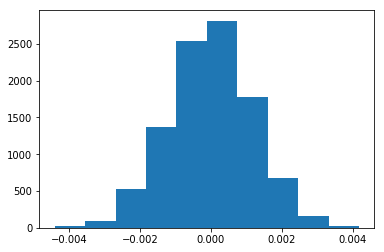

In [40]:
# plot null distribution
plt.hist(p_diffs);

* Each of the simulated draws here represents a possible p_diff from the null hypothesis
* Given that, one can now ask the question "Where does the observed p_diff fall within this distribution?"  To answer this question, one must:
  * Go back and look at what the observed p_diff was
  * Plot the observed p_diff on the histogram and see where it falls within the distribution
  * If the observed p_diff falls far from the majority of the distribution, then there is evidence to support rejecting the null hypothesis

In [41]:
# # the observed p_diff from ab_data.csv:
p_diff_observed = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
p_diff_observed  # -0.0015782389853555567

-0.0015782389853555567

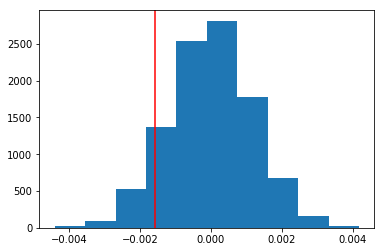

In [42]:
# plot null distribution
plt.hist(p_diffs);

# plot line for observed statistic
plt.axvline(p_diff_observed, c='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [43]:
# compute p value
(p_diffs < p_diff_observed).mean()

0.0937

<a id='PartII_assessment_of_sampling_distr'></a>
([Top of Page](#top_of_page))<br>
k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:**

The value calculated in part **j** is the p-value. The p-value is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true

* Remember that one formulation of the null ($H_0$) and alternative hypotheses ($H_1$) is as follows:
$$H_0: p_{old} - p_{new} \ge 0$$
$$H_1: p_{old} - p_{new} < 0$$<br>

* Since $(p_{old} - p_{new}) = (p\_diff)$, this can be re-written:
$$H_0: (p\_diff) \ge 0$$
$$H_1: (p\_diff) < 0$$<br>

* As such, the probability of observing the sample statistic or one more extreme in favor of the alternative (i.e., the p-value) would be:
  * the probability that $(p\_diff_{from\_null\_distr})$ is less than $(p\_diff_{sample\_statistic})$<br><br>
  
* **Since the acceptable Type 1 error rate, $\alpha$, was declared to be 5%, and the p-value is > 0.05, that means we fail to reject the null hypothesis.**
   * This is also supported by the histogram, above:
     * Since the observed statistic is in the bulk of the distribution and the distribution is under the null hypothesis, this indicates that the null hypothesis cannot be rejected.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [44]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [52]:
convert_old = df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()
convert_new = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

<a id='PartII_z_test'></a>
([Top of Page](#top_of_page))<br>
m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

* edit: as of 5/8/2019, the link provided above does not work. use [this link](https://www.statsmodels.org/devel/generated/statsmodels.stats.proportion.proportions_ztest.html) instead.

In [53]:
z_score, p_value = sm.stats.proportions_ztest(count=[convert_new,convert_old], nobs=[n_new,n_old], alternative = 'smaller')
#z_score, p_value = sm.stats.proportions_ztest(     num successes             ,  num observations , alternative = 'larger')
z_score, p_value

#z_score, p_value = sm.stats.proportions_ztest(count=[convert_old,convert_new], nobs=[n_old,n_new], alternative = 'smaller')

(-1.3109241984234394, 0.09494168724097551)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:**

* z-score:
  * The z-score (or "standard score") represents the "signed fractional number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured." ([reference](https://en.wikipedia.org/wiki/Standard_score)).

  * Since this is a one sided test with the Type I error rate defined as $\alpha$ = 0.05:
    * a z-score <= -1.645 would be considered significant, and would indicate that the null hyphothesis can be rejected.
    * a z-score > -1.645 would not be considered significant, and would indicate that the null hyphothesis can not be rejected. ([reference](http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_HypothesisTest-Means-Proportions/BS704_HypothesisTest-Means-Proportions3.html))

  * Since the z-score is -1.32 (and greater than the critical z-score of -1.645), the null hyphothesis cannot be rejected.<br><br>

* p-value:
  * The p-value is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.
  * In order to reject the null hypothesis, the p-value would need to be <= $\alpha$, the type 1 error threshold for this problem.
  * Since the p-value is 0.0949 and this is > 0.05, the p-value indicates that the null hypothesis can not be rejected.

<a id='regression'></a>
### Part III - A regression approach
([Top of Page](#top_of_page))

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:**
* Logistic regression should be used, since the response variable ("converted") is constrained to a discrete set of possible values (either 0 or 1).

<a id='PartIII_create_init_dummies'></a>
([Top of Page](#top_of_page))<br>
b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [54]:
# copy df2 (for debug purposes), then 
df3 = df2.copy()
df3['intercept'] = 1
df3['ab_page'] = pd.get_dummies(df3['group'])['treatment']
df3.head()

# # the following returns both dummy columns, but is redundant. only one dummy column is needed
# df2[['ab_page','no_ab_page']] = pd.get_dummies(df2['group'])

# # drop the column that is not needed
# df2 = df2.drop('no_ab_page', axis = 1)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


<a id='PartIII_create_init_regression_model'></a>
([Top of Page](#top_of_page))<br>
c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [55]:
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [56]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 13 May 2019   Pseudo R-squ.:               8.077e-06
Time:                        20:14:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [57]:
np.exp(-0.0150)

0.9851119396030626

* For every 1 unit increase in ab_page, conversion is 0.985 times as likely, holding all else constant
  * NOTE: For multiplicative changes less than one, computing the reciprocal changes the direction from a unit increase to a unit decrease.

In [58]:
1/np.exp(-0.0150)

1.015113064615719

* For every 1 unit decrease in ab_page, conversion is 1.015 times as likely, holding all else constant

<a id='PartIII_assess_p_value'></a>
([Top of Page](#top_of_page))<br>
e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer:**
* The p value is 0.190, which is not statistically significant (i.e., not below an $\alpha$ of 0.05)<br>
* This p-value is different from results in **Part II** because the null and alternative hypotheses are different.
  * In short, **Part III** is a two-sided test, whereas **Part II** is a one-sided test 

**Discussion:**
* In **Part II**, the null hypothesis and alternative hypotheses were as follows:
  * Null Hypothesis ($H_0$): the conversion rate for the old page is greater than or equal to the conversion rate of the new page.
  * Alternative Hypothesis ($H_1$): the conversion rate for the old page is less than the conversion rate of the new page.
  * Expressions for ($H_0$) and ($H_1$) in **Part II**:
$$H_0: p_{old} \ge p_{new}$$
$$H_1: p_{old} < p_{new}$$<br>
  * Other ways to express ($H_0$) and ($H_1$):
$$H_0: p_{old} - p_{new} \ge 0$$
$$H_1: p_{old} - p_{new} < 0$$<br>

* However, **Part III** utilizes a logistic regression model. As such, it is testing for the existence of a relationship between independent and response variables and represents a two-sided test.
* The null and alternative hypotheses for **Part III** are as follows:
  * Null Hypothesis ($H_0$): there is no difference in conversion rate between the new and old pages
  * Alternative Hypothesis ($H_1$): there is a difference in conversion rate betweent the new pages
  * Expressions for ($H_0$) and ($H_1$):
$$H_0: converted_{old\_page} = converted_{new\_page}$$
$$H_1: converted_{old\_page} \ne converted_{new\_page}$$<br>
  * In such a regression, small p-values (typically, $p\_values \le \alpha$, where $\alpha$ = 0.05), indicate that a given variable is statistically significant relative to the response variable (in this case, the "converted" parameter)

<a id='PartIII_consider_adding_factors'></a>
([Top of Page](#top_of_page))<br>
f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**
* Adding other factors to an analysis carries some **potential advantages**. Some of them include:
  * Learning more about underlying trends within the data
  * Discovering and/or adding new data features
  * Determining and removing outliers
  * Maximizing the value and insights that the analysis provides
  * Enabling the analyst to perform additional feature engineering ([Wikipedia - "Feature Engineering"](https://en.wikipedia.org/wiki/Feature_engineering))
  * Increasing the predictive capability of model(s) that are based on the data<br><br>
  
* Adding other factors to an analysis also carries some **potential disadvantages**. Some of them include:
  * Increasing the complexity of predictive models
     * Models may require the addition of higher order terms
     * The models themselves may need to be analyzed and refined
  * Adding factors that are collinear with existing factors. This could potentially:
     * Increase a model's ability to predict at the expense of being able to interpret the model's components
     * Decrease the statistical significance of predictive variables, even when their practical significance remains unchanged

<a id='PartIII_add_country_factors'></a>
([Top of Page](#top_of_page))<br>
g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [63]:
countries_df = pd.read_csv('./countries.csv')
countries_df.head()
#df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')
df_new = countries_df.join(df3.set_index('user_id'),on='user_id',how='inner')
df_new.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


<a id='PartIII_analyze_effect_of_additional_factors'></a>
([Top of Page](#top_of_page))<br>
Does it appear that country had an impact on conversion? Don't forget to create dummy variables for these country columns - Hint: You will need two columns for the three dummy variables. Provide the statistical output as well as a written response to answer this question.

In [64]:
#check the new df for which unique entries exist in the "country" column
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [65]:
# define the intercept as == 1
df_new['intercept'] = 1

# the following returns all dummy columns, but is redundant. one of the dummy columns is not needed
df_new[['CA','UK', 'US']] = pd.get_dummies(df_new['country'])

# drop the first dummy variable (country == 'CA'), since only n-1 dummy variables are needed
# this dropped dummy will become a baseline variable
df_new = df_new.drop('CA', axis = 1)
df_new.tail()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
290579,653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,0,0,1
290580,878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,0,1,0
290581,799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,0,1,0
290582,655535,CA,2017-01-09 13:30:47.524512,treatment,new_page,0,1,1,0,0
290583,934996,UK,2017-01-09 00:30:08.377677,control,old_page,0,1,0,1,0


In [66]:
logit_mod_countries = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
results_countries = logit_mod_countries.fit()
results_countries.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 13 May 2019   Pseudo R-squ.:               2.323e-05
Time:                        20:15:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [68]:
1/np.exp(-0.0149), np.exp(0.0506), np.exp(0.0408)

(1.0150115583846535, 1.0519020483004984, 1.0416437559600236)

In [69]:
y, X = dmatrices('converted ~ ab_page + UK + US', df_new, return_type = 'dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 

In [70]:
vif

,VIF Factor,features
0,21.055923,Intercept
1,1.000006,ab_page
2,4.502236,UK
3,4.502223,US


Does it appear that country had an impact on conversion? <br><br>

**Answer:**
* **Interpretation of coefficients (assuming no collinearity):**
  * For every 1 unit that 'ab_page' decreases, conversion is 1.015 times as likely, holding all else constant
  * For every 1 unit that 'UK' increases, conversion is 1.052 times as likely, holding all else constant
  * For every 1 unit that 'US' increases, conversion is 1.042 times as likely, holding all else constant<br><br>
* **Since neither 'ab_page', 'UK', nor 'US' have a high VIF (i.e., a VIF > 10), they can be presumed to be independent of one another**
  * Although the "Intercept" variable has a high VIF factor, it can be overlooked since VIF's measure the effect of collinearity on regression coefficients
    * [Wikipedia](https://en.wikipedia.org/wiki/Variance_inflation_factor#Interpretation):  [The variance inflaction factor] *"provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity"*<br><br>
* **However, since the 'ab_page' and 'country' variables each have p-values larger than 0.05, they are not statistically significant with respect to predicting the value of 'converted'.**
  * Even if they were statistically significant, the fact that they range from 1.5% difference against the baseline (for 'ab_page') to 5.2% difference against the baseline (for 'UK') indicates that they may not be practically significant.
  * i.e., depending on the company goals and metrics involved, a 1.5% to 5.2% difference in a parameter may not be sufficient to warrant changing one of the company's key products (in this case, its web page).<br><br>


<a id='PartIII_check_for_interactions'></a>
([Top of Page](#top_of_page))<br>
h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [71]:
# create the new dummy columns
df_new_interact = df_new.copy()
df_new_interact['UK_new'] = df_new['UK']*df_new['ab_page']
df_new_interact['US_new'] = df_new['US']*df_new['ab_page']
df_new_interact.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,UK_new,US_new
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,1,0


In [72]:
# fit the new model
logit_mod_countries_interact = sm.Logit(df_new['converted'], df_new_interact[['intercept', 'ab_page', 'UK', 'US', 'UK_new', 'US_new']])
results_countries_interact = logit_mod_countries_interact.fit()
results_countries_interact.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 13 May 2019   Pseudo R-squ.:               3.482e-05
Time:                        20:16:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK_new         0.0783      0.057      1.378      0.168      -0.033       0.190
US_new         0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

In [75]:
results_countries_interact.params.US

0.01752782018451708

In [ ]:
# interpret the coefficients:
# np.exp(results_countries_interact.params)

In [ ]:
# interpret the coefficients
#np.exp(results_countries.params)

In [73]:
y, X = dmatrices('converted ~ ab_page + UK + US + UK_new + US_new', df_new_interact, return_type = 'dataframe')

vif_interact = pd.DataFrame()
vif_interact["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_interact["features"] = X.columns 
vif_interact

,VIF Factor,features
0,40.370103,Intercept
1,20.042669,ab_page
2,9.052871,UK
3,9.065123,US
4,10.469097,UK_new
5,19.555056,US_new


<a id='conclusions'></a>
([Top of Page](#top_of_page))
## Conclusions

### Regarding Interaction Terms:
* **Since the coefficients have interaction terms, a given coefficient is no longer a sufficient analog for the change in the response variable per unit increase in the predictor variable.**<br><br>
  * i.e., although calculating `np.exp(results_countries.params.US)` indicated that for every 1 unit that 'US' increases, conversion was 1.042 times as likely, the corresponding charactertistic is not true for `np.exp(results_countries_interact.params.US)`, since the latter contains multiple variables that are a function of 'US'<br><br>
  
* **The interaction variables are can be removed from the multiple linear regression model, since their VIF factors indicate that each of them is correlated with the 'ab_page' variable.**
  * Per the course notes (Lesson 15, Video 18, "Multicollinearity & VIF's):
    * *"The most common way of working with correlated explanatory variables ... is simply to remove [those variables that are] most related to the other variables."*<br><br>
  
* **In addition, the interaction variables each have p-values larger than 0.05, further indicating that they are not statistically significant with respect to predicting the value of 'converted'.**
  * More on this in the upcoming 'Final Thoughts' section below.<br>

([Top of Page](#top_of_page))
### Final Thoughts:
#### Original Null and Alternative Hypotheses:
* The null hypothesis is that the conversion rate for the old page is greater than or equal to the conversion rate of the new page.
* The alternative hypothesis is that the conversion rate for the old page is less than the conversion rate of the new page.
* Expressions for the null ($H_0$) and alternative hypotheses ($H_1$) are as follows:

$$H_0: p_{old} \ge p_{new}$$
$$H_1: p_{old} < p_{new}$$

* Another way to write the null and alternative hypothesis expressions:

$$H_0: p_{old} - p_{new} \ge 0$$
$$H_1: p_{old} - p_{new} < 0$$

#### Assessment of Sampling Distribution:
* **Since the acceptable Type 1 error rate, $\alpha$, was declared to be 5%, and the p-value is > 0.05, that means we fail to reject the null hypothesis.**
   * This is also supported by the histogram, above:
     * Since the observed statistic is in the bulk of the distribution and the distribution is under the null hypothesis, this indicates that the null hypothesis cannot be rejected.<br><br>

#### Assessment of Z-scores, using a built-in:
**Answer:**

* z-score:
  * The z-score (or "standard score") represents the "signed fractional number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured." ([reference](https://en.wikipedia.org/wiki/Standard_score)).

  * Since this is a one sided test with the Type I error rate defined as $\alpha$ = 0.05:
    * a z-score <= -1.645 would be considered significant, and would indicate that the null hyphothesis can be rejected.
    * a z-score > -1.645 would not be considered significant, and would indicate that the null hyphothesis can not be rejected. ([reference](http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_HypothesisTest-Means-Proportions/BS704_HypothesisTest-Means-Proportions3.html))

  * Since the z-score is -1.32 (and greater than the critical z-score of -1.645), the null hyphothesis cannot be rejected.<br><br>

* p-value:
  * The p-value is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.
  * In order to reject the null hypothesis, the p-value would need to be <= $\alpha$, the type 1 error threshold for this problem.
  * Since the p-value is 0.0949 and this is > 0.05, the p-value indicates that the null hypothesis can not be rejected.

#### Assessment of Multiple Linear Regression Model:
* **However, since the 'ab_page' and 'country' variables each have p-values larger than 0.05, they are not statistically significant with respect to predicting the value of 'converted'.**
  * Even if they were statistically significant, the fact that they range from 1.5% difference against the baseline (for 'ab_page') to 5.2% difference against the baseline (for 'UK') indicates that they may not be practically significant.
  * i.e., depending on the company goals and metrics involved, a 1.5% to 5.2% difference in a parameter may not be sufficient to warrant changing one of the company's key products (in this case, its web page).<br><br>

#### Assessment of Multiple Logistic Regression Model:
* Logistic regression should be used, since the response variable ("converted") is constrained to a discrete set of possible values (either 0 or 1).

  * The p value is 0.190, which is not statistically significant (i.e., not below an $\alpha$ of 0.05)<br>
* This p-value is different from results in **Part II** because the null and alternative hypotheses are different.
  * In short, **Part III** is a two-sided test, whereas **Part II** is a one-sided test 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.